In [1]:
import zipfile

import matplotlib.pyplot as plt

from hda import Client

import geopandas as gpd
import pandas as pd
#from geocube.api.core import make_geocube
%run helpers.ipynb

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
data = {
    "datasetId": "EO:CLMS:DAT:CORINE",
    "stringChoiceValues": [
        {
            "name": "product_type",
            "value": "Corine Land Cover 2018"
        },
        {
            "name": "format",
            "value": "GeoPackage"
        }
    ]
}

In [3]:
c = Client(debug=False)

matches = c.search(data)
matches.download()

Exception: Missing/incomplete configuration file: /home/jovyan/.hdarc

In [ ]:
zip_ref = zipfile.ZipFile("u2018_clc2018_v2020_20u1_geoPackage.zip")
zip_ref.extractall("./data")
zip_ref.close() # close file

In [3]:
gdf = gpd.read_file("data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg")

In [28]:
ledgend = pd.read_csv("data/u2018_clc2018_v2020_20u1_geoPackage/Legend/CLC_legend.csv", delimiter = ";")
ledgend["RGB"] = ledgend["RGB"].fillna("000-000-000")
ledgend["RGB"] = ledgend["RGB"].apply(lambda c : '#%02x%02x%02x'%tuple(int(x) for x in c.split("-"))) # convert RGB to hex
code_color = pd.Series(ledgend.RGB.values,index=ledgend.CLC_CODE).to_dict()
gdf["color"] = gdf["Code_18"].apply(lambda code: code_color[int(code)])



In [29]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [30]:
spain = gpd.clip(gdf, world[world["name"] == "Spain"].to_crs("EPSG:3035"))

<AxesSubplot:>

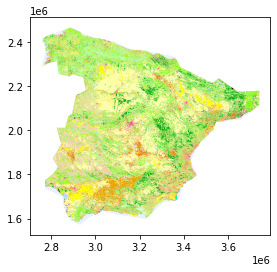

In [31]:
spain.plot( color=spain['color'] )

In [ ]:
import matplotlib.pyplot as plt
plt.savefig("spain.svg")


In [ ]:
gdf.crs